In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
train = pd.read_csv('train.csv').astype('float32') / 255
train['label'] = train['label'] * 255
train = train.astype({'label': 'int64'})
test = pd.read_csv('test.csv').astype('float32') / 255
test['id'] = test['id'] * 255
DigMnist = pd.read_csv('Dig-MNIST.csv').astype('float32') / 255
DigMnist['label'] = DigMnist['label'] * 255
DigMnist = DigMnist.astype({'label': 'int64'})
Train = pd.concat([train, DigMnist], axis=0)
yTrainData = Train['label']
Train = Train.drop(columns = ['label'])

In [3]:
tensorDataset = TensorDataset(torch.tensor(Train.to_numpy().reshape(-1, 1, 28, 28)), torch.tensor(yTrainData.to_numpy()))
total_size = len(tensorDataset)

train_size = int(total_size * 0.8)
test_size = total_size - train_size

train_dataset, test_dataset = random_split(
    tensorDataset, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42) # fixed seed
)
train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [4]:
class KannadaMnistModel(nn.Module):
    def __init__(self):
        super(KannadaMnistModel, self).__init__()
        def make_conv_group(in_, out_):
            return nn.Sequential(
                nn.Conv2d(in_, out_, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                nn.BatchNorm2d(out_, momentum=0.05),
                nn.ReLU(inplace=True)
            )
        
        self.layers = nn.Sequential(
            make_conv_group(1, 64),
            make_conv_group(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14x14
            nn.Dropout2d(p=0.1),
            
            make_conv_group(128, 128),
            make_conv_group(128, 256),
            nn.MaxPool2d(kernel_size=2, stride=2), # 7x7
            nn.Dropout2d(p=0.1),
            
            make_conv_group(256, 256),
            make_conv_group(256, 512),
            nn.MaxPool2d(kernel_size=2, stride=2), # 3x3
            nn.Dropout2d(p=0.1),
            
            make_conv_group(512, 256),
            # 마지막에 크기를 고정해주는 레이어 추가 (안전장치)
            nn.AdaptiveAvgPool2d((1, 1)) # 어떤 크기든 1x1로 압축
        )
        
        # AdaptiveAvgPool2d(1,1) 덕분에 최종 피처맵 크기는 256이 됨
        self.head = nn.Linear(256, 10)
        
        # 가중치 초기화
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        # 입력 데이터가 [Batch, 1, 28, 28]인지 확인
        if x.dim() == 2:
            x = x.view(-1, 1, 28, 28)
            
        x = self.layers(x)
        x = x.view(x.size(0), -1) # flatten
        x = self.head(x)
        # 주의: CrossEntropyLoss를 사용한다면 여기서 Softmax를 빼는 것이 성능과 수치 안정성에 굳
        return x 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("start training...")

model = KannadaMnistModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
EPOCH = 14

Using device: cuda
start training...


In [6]:
trainLoss, testLoss = [], []
trainAcc, testAcc = [], []

for epoch in tqdm(range(0, EPOCH), leave=False):
    
    train_total_loss, train_correct, train_total = 0, 0, 0
    train_loss, train_accuracy = 0, 0
    model.train()
    for batch_x, batch_y in tqdm(train_dataloader, leave=False):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()
        pred = outputs.argmax(dim=1)
        train_correct += (pred == batch_y).sum().item()
        train_total += batch_y.size(0)
    train_loss = train_total_loss / len(train_dataloader)
    train_accuracy = train_correct / train_total

    test_total_loss, test_correct, test_total = 0, 0, 0
    test_loss, test_accuracy = 0, 0
    model.eval()
    for batch_x, batch_y in tqdm(test_dataloader, leave=False):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        test_total_loss += loss.item()
        pred = outputs.argmax(dim=1)
        test_correct += (pred == batch_y).sum().item()
        test_total += batch_y.size(0)
    test_loss = test_total_loss / len(test_dataloader)
    test_accuracy = test_correct / test_total

    trainLoss.append(train_loss)
    trainAcc.append(train_accuracy)
    testLoss.append(test_loss)
    testAcc.append(test_accuracy)

    print(
        f"[Epoch {epoch+1}/{EPOCH}] "
        f"Train Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f} | "
        f"Val Loss: {test_loss:.4f}, Acc: {test_accuracy:.4f}"
        )

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

[Epoch 1/14] Train Loss: 0.1055, Acc: 0.9707 | Val Loss: 0.0570, Acc: 0.9816


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

[Epoch 2/14] Train Loss: 0.0418, Acc: 0.9872 | Val Loss: 0.0717, Acc: 0.9785


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

[Epoch 3/14] Train Loss: 0.0308, Acc: 0.9904 | Val Loss: 0.0427, Acc: 0.9874


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

[Epoch 4/14] Train Loss: 0.0238, Acc: 0.9924 | Val Loss: 0.0397, Acc: 0.9878


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

[Epoch 5/14] Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.0290, Acc: 0.9915


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

[Epoch 6/14] Train Loss: 0.0173, Acc: 0.9947 | Val Loss: 0.0290, Acc: 0.9921


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

[Epoch 7/14] Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0265, Acc: 0.9922


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

[Epoch 8/14] Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0255, Acc: 0.9933


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

[Epoch 9/14] Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0241, Acc: 0.9931


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

[Epoch 10/14] Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0200, Acc: 0.9942


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

[Epoch 11/14] Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0391, Acc: 0.9900


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

[Epoch 12/14] Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0239, Acc: 0.9937


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

[Epoch 13/14] Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0393, Acc: 0.9905


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

[Epoch 14/14] Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0235, Acc: 0.9935


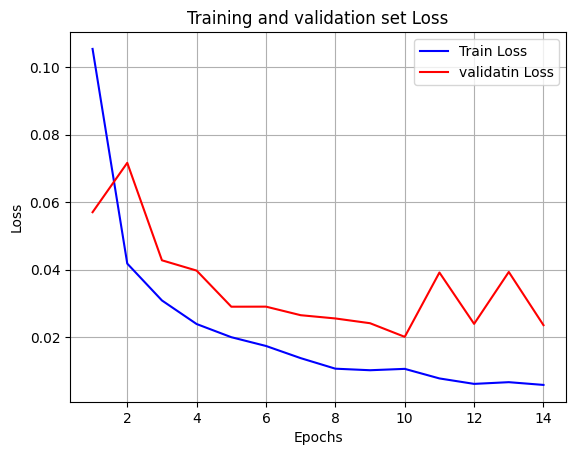

In [7]:
plt.plot(range(1, EPOCH + 1), trainLoss, 'b', label='Train Loss')
plt.plot(range(1, EPOCH + 1), testLoss, 'r', label='validatin Loss')

plt.title('Training and validation set Loss')
plt.xlabel('Epochs')           
plt.ylabel('Loss')               
plt.legend()                       
plt.grid(True)                     

plt.show()

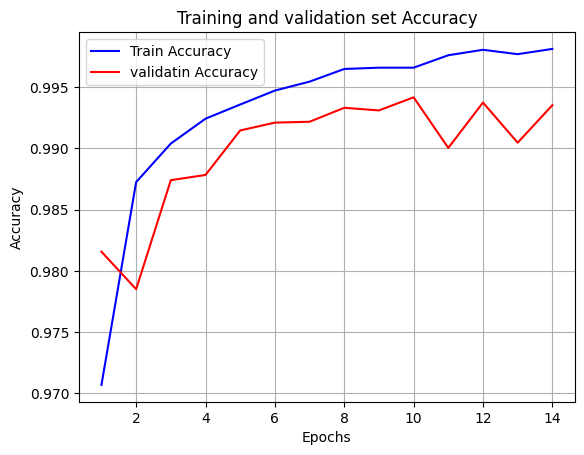

In [8]:
plt.plot(range(1, EPOCH + 1), trainAcc, 'b', label='Train Accuracy')
plt.plot(range(1, EPOCH + 1), testAcc, 'r', label='validatin Accuracy')

plt.title('Training and validation set Accuracy')
plt.xlabel('Epochs')         
plt.ylabel('Accuracy')             
plt.legend()                 
plt.grid(True)               

plt.show()

In [9]:
remainTest = test.drop(columns=['id'])
testTensorDataset = TensorDataset(torch.tensor(remainTest.to_numpy().reshape(-1, 1, 28, 28)))
Test_dataloader = DataLoader(testTensorDataset, batch_size=64)

In [10]:
model.eval()
results = []

# batch_x 뒤에 쉼표(,)를 붙여서 튜플/리스트를 언패킹
for (batch_x, ) in tqdm(Test_dataloader):
    # 이제 batch_x는 리스트가 아닌 텐서입니다!
    batch_x = batch_x.to(device) 
    
    with torch.no_grad():
        outputs = model(batch_x)
        results.extend(outputs.argmax(dim=1).cpu().numpy())

  0%|          | 0/79 [00:00<?, ?it/s]

In [11]:
results2 = []
for a in results:
    results2.append(a.item())

In [12]:
submission = pd.DataFrame({
    'id': range(0, 5000),
    'label': results2
})
submission.to_csv('submission.csv', index=False)

In [13]:
submission

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7
...,...,...
4995,4995,1
4996,4996,1
4997,4997,1
4998,4998,6
